# Dependencias requeridas

In [ ]:
!pip install scikit-learn mediapipe opencv-python seaborn

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard

2024-04-14 14:01:45.115232: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-14 14:01:45.490046: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 14:01:45.490091: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 14:01:45.555453: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-14 14:01:45.694052: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-14 14:01:45.695448: I tensorflow/core/platform/cpu_feature_guard.cc:1

### Atajos para utilidades

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities


## Utilidades para detección y visualización de puntos clave

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connectio

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS, 
    #                          mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
    #                          mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
    #                          ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [7]:
from scipy import stats

colors = [
    (78, 55, 100),
    (13, 250, 85),
    (52, 170, 11),
    (128, 166, 153),
    (252, 160, 11),
    (241, 86, 54),
    (246, 94, 126),
    (69, 241, 201),
    (226, 32, 231), 
    (84, 102, 226)
]

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

### Prueba de las utilidades

In [16]:
%%script true
W=640
H=480

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc('M','J','P','G'))
#cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc('Y','U','Y','V'))
cap.set(cv2.CAP_PROP_FRAME_WIDTH, W)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, H)
cap.set(cv2.CAP_PROP_FPS, 30)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            continue
    
        image, results = mediapipe_detection(frame, holistic)
    
        draw_landmarks(image, results)
        
        cv2.imshow('usb cam test', image)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

E0000 00:00:1713118397.031524    2063 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1713118397.031597    2063 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1713118397.031604    2063 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1713118397.031611    2063 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1713118397.031616    2063 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1713118397.03

## Definición de directorios y parámetros de video

In [9]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('v3', 'MP_Data') 

# Actions that we try to detect
actions = np.array([
    'aceleracion',
    'calculo',
    'computadora',
    'constante',
    'derivada',
    'ecuacion',
    'fisica',
    'formula',
    'inversa',
    'software',
])

# Thirty videos worth of data
n_sequences = 90

# Videos are going to be 30 frames in length
sequence_length = 29

# Folder start
start_folder = 0


### Etiquetas usadas en las predicciones

In [10]:
label_map = {label:num for num, label in enumerate(actions)}

In [11]:
label_map

{'aceleracion': 0,
 'calculo': 1,
 'computadora': 2,
 'constante': 3,
 'derivada': 4,
 'ecuacion': 5,
 'fisica': 6,
 'formula': 7,
 'inversa': 8,
 'software': 9}

### Carga del dataset en formato numpy a memoria

In [55]:
sequences, labels = [], []

# These sequences were found not suitable for training
excluded = {
    "computadora": [58],
    "aceleracion": [62, 75],
    "constante": [42],
}

for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        if sequence in excluded.get(action, []):        
            print(f"sequence {sequence} for action {action} is excluded")
            continue
        
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

sequence 75 for action aceleracion is excluded
sequence 62 for action aceleracion is excluded
sequence 58 for action computadora is excluded
sequence 42 for action constante is excluded


### Inspección de los datos

In [56]:
np.array(sequences).shape

(896, 29, 1662)

In [57]:
X = np.array(sequences)

In [58]:
X.shape

(896, 29, 1662)

In [59]:
y = to_categorical(labels).astype(int)

## Partición del dataset para entrenamiento y pruebas

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [61]:
y_train.shape

(851, 10)

In [62]:
y_test.shape

(45, 10)

#### Parámetros de TensorBoard

In [63]:
log_dir = os.path.join('Logs', 'CNN')
tb_callback = TensorBoard(log_dir=log_dir)

## Definición del primer modelo evaluado: LSTM

In [12]:
modelLSTM = Sequential()
modelLSTM.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(29,1662)))
modelLSTM.add(LSTM(256, return_sequences=True, activation='relu'))
modelLSTM.add(LSTM(128, return_sequences=False, activation='relu'))
modelLSTM.add(Dense(256, activation='relu'))
modelLSTM.add(Dense(32, activation='relu'))
modelLSTM.add(Dense(actions.shape[0], activation='softmax'))

2024-04-14 14:02:23.910501: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-14 14:02:24.072863: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [13]:
modelLSTM.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [47]:
#modelLSTM.fit(X_train, y_train, epochs=100, callbacks=[tb_callback])

Epoch 1/100
36/36 [==============================] - 4s 101ms/step - loss: 0.3735 - categorical_accuracy: 0.8762
Epoch 2/100
36/36 [==============================] - 4s 99ms/step - loss: 0.4567 - categorical_accuracy: 0.8335
Epoch 3/100
36/36 [==============================] - 3s 96ms/step - loss: 0.4694 - categorical_accuracy: 0.8459
Epoch 4/100
36/36 [==============================] - 4s 97ms/step - loss: 0.7026 - categorical_accuracy: 0.7569
Epoch 5/100
36/36 [==============================] - 3s 95ms/step - loss: 0.5856 - categorical_accuracy: 0.8059
Epoch 6/100
36/36 [==============================] - 3s 95ms/step - loss: 1.6042 - categorical_accuracy: 0.4978
Epoch 7/100
36/36 [==============================] - 4s 97ms/step - loss: 1.0060 - categorical_accuracy: 0.6233
Epoch 8/100
36/36 [==============================] - 3s 96ms/step - loss: 0.7993 - categorical_accuracy: 0.7150
Epoch 9/100
36/36 [==============================] - 3s 96ms/step - loss: 0.7713 - categorical_accuracy

In [52]:
modelLSTM.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 29, 128)           916992    
                                                                 
 lstm_17 (LSTM)              (None, 29, 256)           394240    
                                                                 
 lstm_18 (LSTM)              (None, 128)               197120    
                                                                 
 dense_15 (Dense)            (None, 256)               33024     
                                                                 
 dense_16 (Dense)            (None, 32)                8224      
                                                                 
 dense_17 (Dense)            (None, 10)                330       
                                                                 
Total params: 1549930 (5.91 MB)
Trainable params: 1549

In [22]:
res = modelLSTM.predict(X_test)

2/2 [==============================] - 0s 27ms/step


In [25]:
print(actions[np.argmax(res[4])])
print(actions[np.argmax(y_test[4])] )


computadora
formula


In [45]:
#modelLSTM.save('LSTM model v2.h5')

/home/carlos/miniconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
modelLSTM.load_weights('models/LSTM model.h5')

In [67]:
yhat = modelLSTM.predict(X_test)

2/2 [==============================] - 0s 29ms/step


In [68]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [69]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

multilabel_confusion_matrix(ytrue, yhat)

array([[[41,  0],
        [ 0,  4]],

       [[41,  0],
        [ 0,  4]],

       [[43,  0],
        [ 0,  2]],

       [[42,  0],
        [ 0,  3]],

       [[37,  0],
        [ 1,  7]],

       [[42,  0],
        [ 0,  3]],

       [[41,  0],
        [ 0,  4]],

       [[39,  0],
        [ 0,  6]],

       [[38,  1],
        [ 0,  6]],

       [[40,  0],
        [ 0,  5]]])

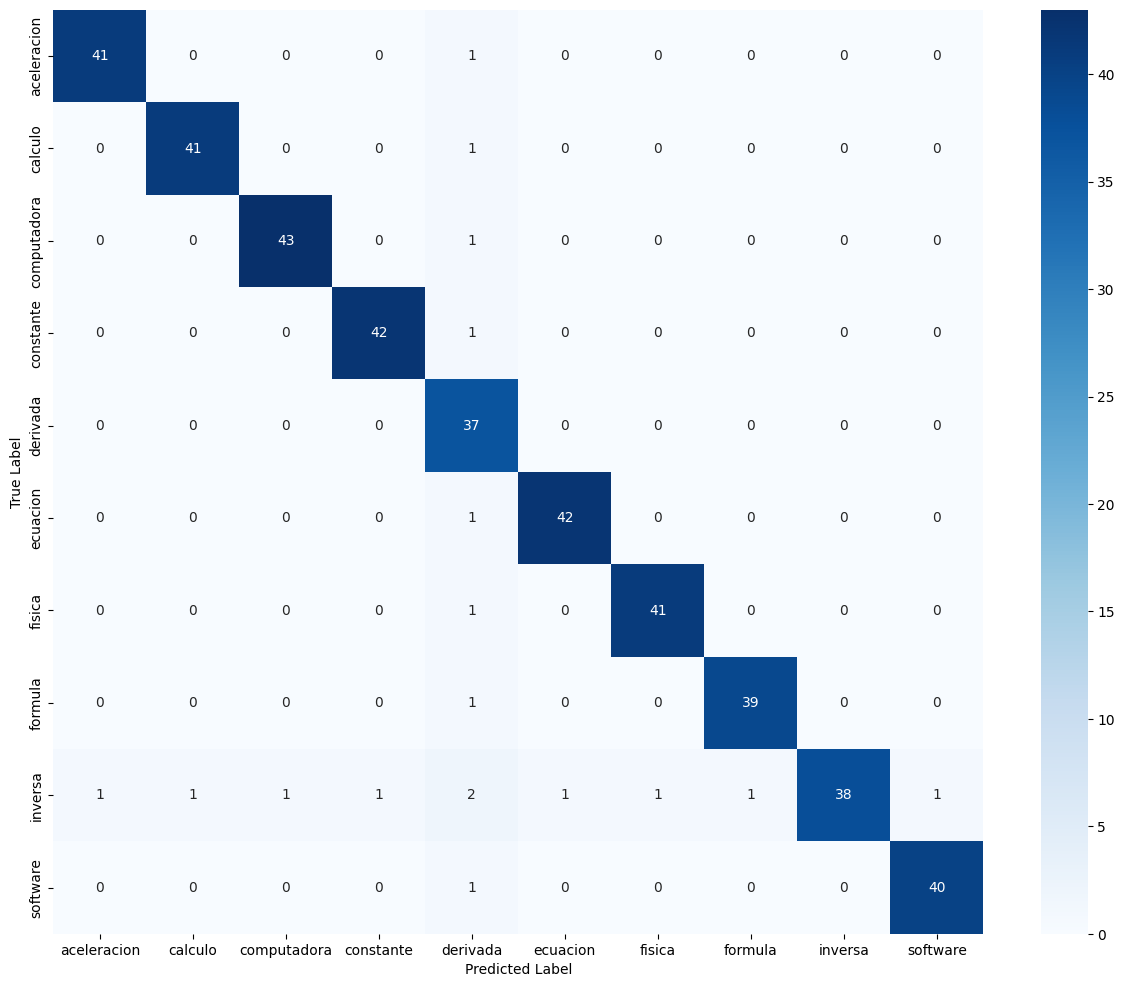

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# Assuming y_true and y_pred are your true and predicted labels respectively
# For example:
# y_true = np.array([[1, 0, 1], [0, 1, 0], [1, 1, 1]])
# y_pred = np.array([[1, 0, 0], [0, 1, 1], [1, 0, 1]])

mcm = multilabel_confusion_matrix(ytrue, yhat)
n_labels = mcm.shape[0]

# Initialize a matrix to hold the combined results
combined_matrix = np.zeros((n_labels, n_labels), dtype=int)

for i in range(n_labels):
    for j in range(n_labels):
        if i == j:
            # True positives are on the diagonal
            combined_matrix[i, j] = mcm[i, 0, 0]
        else:
            # False positives for column label or false negatives for row label
            # are on the off-diagonals
            combined_matrix[i, j] = mcm[i, 0, 1] + mcm[j, 1, 0]

# Now, combined_matrix is organized in the structure similar to your heatmap
#Let's create a heatmap from this combined matrix
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(combined_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)

# Assuming you have a list of label names
label_names = actions  # Replace with your actual label names
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

plt.show()


In [71]:
accuracy_score(ytrue, yhat)

0.9777777777777777

### Creando una copia con dimensiones adecuadas para el segundo modelo utilizado: CNN

In [33]:
print(X_train.shape)
print(y_train.shape)

(851, 29, 1662)
(851, 10)


In [72]:
X_train2 = X_train.copy()  # replace this with your actual array
X_train2 = X_train2.reshape(851, 29, 1662, 1)

y_train2 = y_train.copy()
y_train2 = np.argmax(y_train2, axis=1)

print(X_train2.shape)
print(y_train2.shape)

(851, 29, 1662, 1)
(851,)


## Definición del modelo CNN utilizado

In [79]:
modelCNN = Sequential()
modelCNN.add(Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu', input_shape=(29, 1662, 1)))
modelCNN.add(MaxPooling2D(pool_size=(2, 2), strides=2))
modelCNN.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
modelCNN.add(MaxPooling2D(pool_size=(2, 2), strides=2))
modelCNN.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
modelCNN.add(MaxPooling2D(pool_size=(2, 2), strides=2))
modelCNN.add(Flatten())
modelCNN.add(Dense(32, activation='relu'))
modelCNN.add(Dense(actions.shape[0], activation='softmax'))


In [80]:
modelCNN.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [81]:
modelCNN.fit(X_train2, y_train2, epochs=40, callbacks=[tb_callback])

Epoch 1/40
27/27 [==============================] - 16s 583ms/step - loss: 2.2674 - accuracy: 0.1692
Epoch 2/40
27/27 [==============================] - 15s 565ms/step - loss: 1.9735 - accuracy: 0.2538
Epoch 3/40
27/27 [==============================] - 15s 569ms/step - loss: 1.4922 - accuracy: 0.4630
Epoch 4/40
27/27 [==============================] - 15s 559ms/step - loss: 1.0823 - accuracy: 0.6099
Epoch 5/40
27/27 [==============================] - 15s 573ms/step - loss: 0.9159 - accuracy: 0.6698
Epoch 6/40
27/27 [==============================] - 15s 559ms/step - loss: 0.7691 - accuracy: 0.7168
Epoch 7/40
27/27 [==============================] - 15s 571ms/step - loss: 0.6942 - accuracy: 0.7403
Epoch 8/40
27/27 [==============================] - 15s 565ms/step - loss: 0.5750 - accuracy: 0.8002
Epoch 9/40
27/27 [==============================] - 16s 574ms/step - loss: 0.4745 - accuracy: 0.8578
Epoch 10/40
27/27 [==============================] - 15s 572ms/step - loss: 0.4592 - accura

In [41]:
modelCNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 27, 1660, 32)      320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 13, 830, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 828, 64)       18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 5, 414, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 412, 32)        18464     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 1, 206, 32)       

In [91]:
modelCNN.predict(X_test)

2/2 [==============================] - 0s 53ms/step


array([[0.10610111, 0.09505432, 0.0960225 , 0.10796871, 0.10438889,
        0.09926861, 0.09469628, 0.10184383, 0.09369884, 0.10095692],
       [0.10692616, 0.09521567, 0.09654389, 0.10809133, 0.10219809,
        0.10071487, 0.09493342, 0.100495  , 0.09397068, 0.10091089],
       [0.10604546, 0.09481896, 0.09643511, 0.10871423, 0.10339008,
        0.10088675, 0.0953312 , 0.10002812, 0.09385003, 0.10050005],
       [0.10619036, 0.09552595, 0.09704742, 0.10743649, 0.1024345 ,
        0.10118615, 0.09467085, 0.10018437, 0.09386584, 0.10145804],
       [0.10633226, 0.09493999, 0.09616796, 0.10813578, 0.10300204,
        0.10010937, 0.09488189, 0.10096067, 0.09429128, 0.10117868],
       [0.10697161, 0.09460922, 0.09681141, 0.10878535, 0.10241918,
        0.10091365, 0.09450765, 0.10057569, 0.09388453, 0.10052162],
       [0.10558657, 0.09655238, 0.09627829, 0.10693731, 0.10263295,
        0.0992168 , 0.09346885, 0.10203218, 0.09484751, 0.10244706],
       [0.10684906, 0.09385639, 0.0960465

In [82]:
#modelCNN.save('CNN model v2.h5')

/home/carlos/miniconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [75]:
modelCNN.load_weights('models/CNN model.h5')

In [83]:
yhat = modelCNN.predict(X_test)

ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

2/2 [==============================] - 0s 53ms/step


In [84]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[41,  0],
        [ 0,  4]],

       [[41,  0],
        [ 0,  4]],

       [[43,  0],
        [ 0,  2]],

       [[42,  0],
        [ 0,  3]],

       [[37,  0],
        [ 0,  8]],

       [[41,  1],
        [ 0,  3]],

       [[41,  0],
        [ 0,  4]],

       [[39,  0],
        [ 2,  4]],

       [[38,  1],
        [ 0,  6]],

       [[40,  0],
        [ 0,  5]]])

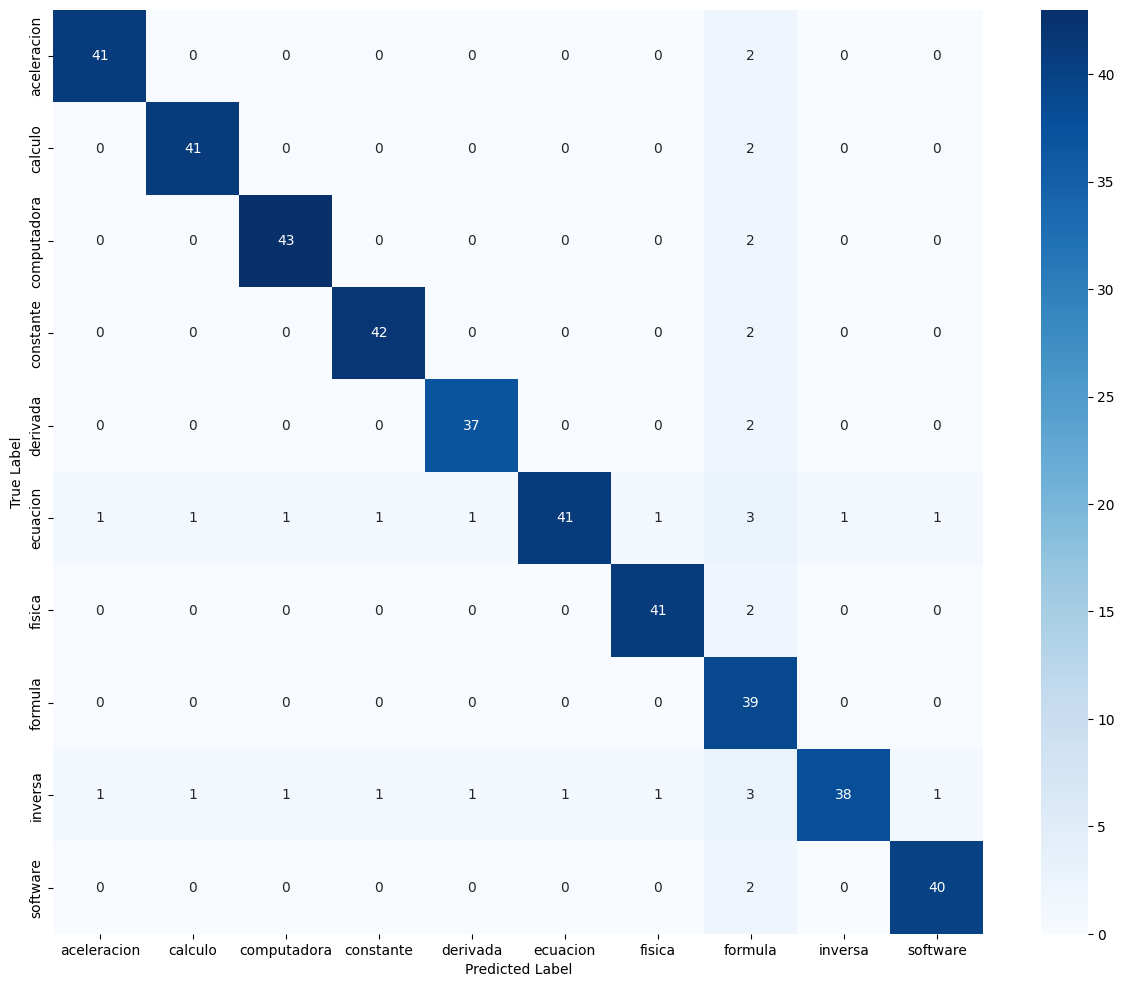

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# Assuming y_true and y_pred are your true and predicted labels respectively
# For example:
# y_true = np.array([[1, 0, 1], [0, 1, 0], [1, 1, 1]])
# y_pred = np.array([[1, 0, 0], [0, 1, 1], [1, 0, 1]])

mcm = multilabel_confusion_matrix(ytrue, yhat)
n_labels = mcm.shape[0]

# Initialize a matrix to hold the combined results
combined_matrix = np.zeros((n_labels, n_labels), dtype=int)

for i in range(n_labels):
    for j in range(n_labels):
        if i == j:
            # True positives are on the diagonal
            combined_matrix[i, j] = mcm[i, 0, 0]
        else:
            # False positives for column label or false negatives for row label
            # are on the off-diagonals
            combined_matrix[i, j] = mcm[i, 0, 1] + mcm[j, 1, 0]

# Now, combined_matrix is organized in the structure similar to your heatmap
# Let's create a heatmap from this combined matrix
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(combined_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)

# Assuming you have a list of label names
label_names = actions  # Replace with your actual label names
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

plt.show()


In [86]:
accuracy_score(ytrue, yhat)

0.9555555555555556

## Ejecución del Motor de Reconocimiento de la LSV

In [15]:
model = modelLSTM


# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5


W=640
H=480
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc('M','J','P','G'))

cap.set(cv2.CAP_PROP_FRAME_WIDTH, W)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, H)
cap.set(cv2.CAP_PROP_FPS, 30)

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        # print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-29:]
        
        if len(sequence) == 29:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

E0000 00:00:1713117764.978483    2063 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1713117764.978530    2063 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1713117764.978540    2063 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1713117764.978548    2063 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1713117764.978556    2063 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1713117764.97

1/1 [==============================] - 0s 304ms/step
formula
1/1 [==============================] - 0s 28ms/step
formula
1/1 [==============================] - 0s 30ms/step
formula
1/1 [==============================] - 0s 29ms/step
formula
1/1 [==============================] - 0s 29ms/step
formula
1/1 [==============================] - 0s 26ms/step
formula
1/1 [==============================] - 0s 25ms/step
formula
1/1 [==============================] - 0s 26ms/step
formula
1/1 [==============================] - 0s 28ms/step
formula
1/1 [==============================] - 0s 25ms/step
formula
1/1 [==============================] - 0s 26ms/step
formula
1/1 [==============================] - 0s 27ms/step
formula
1/1 [==============================] - 0s 24ms/step
formula
1/1 [==============================] - 0s 24ms/step
formula
1/1 [==============================] - 0s 25ms/step
formula
1/1 [==============================] - 0s 24ms/step
formula
1/1 [==============================] - 

In [41]:
cap.release()
cv2.destroyAllWindows()